**CV2021 - Week 2**

**CONTENTS**
  1. [**2D convolution**](https://colab.research.google.com/drive/1WwWwhEFWDwVhm7_37iyyyZEy--ctt1XO#scrollTo=MWkjxXSorQRr)

  2. [**Bayer Filter and demosaicing**](https://colab.research.google.com/drive/1WwWwhEFWDwVhm7_37iyyyZEy--ctt1XO#scrollTo=nXjVF4qjXY17&line=38&uniqifier=1)


  3. [**Cameral calibration**](https://colab.research.google.com/drive/1WwWwhEFWDwVhm7_37iyyyZEy--ctt1XO#scrollTo=tpW11Ie9WmT4&line=1&uniqifier=1)

  4. [**Image distorsion**](https://colab.research.google.com/drive/1WwWwhEFWDwVhm7_37iyyyZEy--ctt1XO#scrollTo=W67jYMo9owjz&line=1&uniqifier=1)


**HOMEWORK**

1. Using the *wand.image* Python package, simulate the Barrel distorsion, as described in the next image.

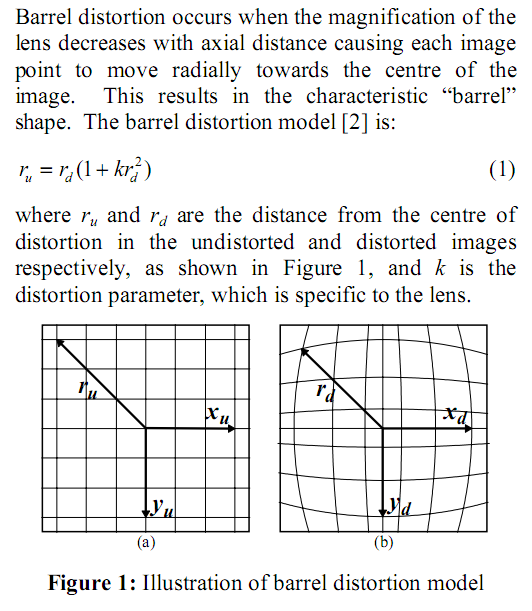


2. Using *scipy.optimize.fmin*, and starting with the DLT guess for the projection matrix P, compute a matrix that will minimize the reprojection error. Eventually, using the calibration pattern, determine a set of points producing a better guess. Compare the camera parameters with the ones produced by DLT.


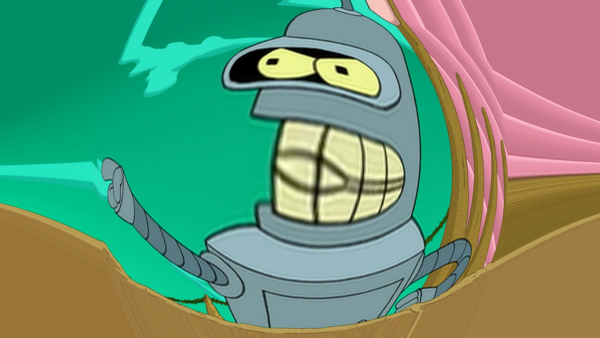

In [51]:
from wand.image import Image

with Image(filename="./bender.png") as img:
    img.distort("barrel",(0.4, 0.0, 0.4))
    display(img)

**1) The convolution operation from the w1 homework**

In this example, two different approaches for the implementation of a 2D correlation operation are going to be implemented. 

In a sliding window fashion, the correlation operation can be implemented by moving the correlation mask along the image, computing the dot product between the local patch vector and the correlation mask. The local patch is considered the set of neighboring pixels, centered in the local processed pixel, with the same size as the correlation mask.

If the correlation mask is symmetrical, the correlation operation is equivalent to a convolution.

To benefit from the advantage of doing parallel computing, we are going to compare the runtime for an iterative version vs. the elementwise multiplication followed by a summation reduction.

The input image is going to need padding. In this solution zero-padding is implemented, but other types of padding are widely used. 

The following image offers a graphical representation of the convolution operation.

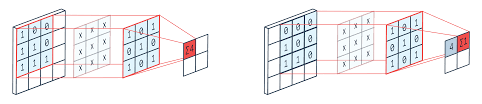

About the **code structure**, Python offers the posibility to use functions as arguments. So, the generic convolution operation si going to be equipped with a parametrizable function argument, and then, reasoning about the runtime with respect to the performed operations is going to be relatively easy.

The input image is going to be padded, and the indiced are going to be updated with the suitable displacement. For the sake of the simplicity regarding the padding operation, the correlation mask will be a square matrix of an odd number dimension.


In [6]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

def generic_convolution(input_image, correlation_filter, agg_function):
    h, w = input_image.shape
    h_c, w_c = correlation_filter.shape

    d_h = h_c // 2
    d_w = w_c // 2

    oper_image = np.zeros((h + 2 * d_h, w + 2 * d_w))
    plt.imshow(oper_image)
    oper_image[d_h:(h + d_h), d_w:(w + d_w)] = input_image
    output_img = np.zeros((h, w))

    for i in range(h):
        for j in range(w):
          l_i = i + d_h
          l_j = j + d_w
          patch = oper_image[(l_i - d_h):(l_i + d_h + 1), (l_j - d_w):(l_j + d_w + 1)]
          output_img[i, j] = agg_function(patch, correlation_filter)

    return output_img

  

In [7]:
def matrix_sum(a, b):
  result = 0
  h, w = a.shape
  for i in range(h):
    for j in range(w):
      result += a[i, j] * b[i, j]
    return result

def numpy_sum(a, b):
  return np.sum(a * b)

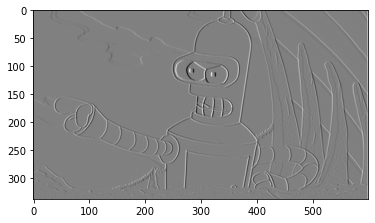

In [8]:
bender_img = cv.imread("./bender.png")
bender_img_gray = cv.cvtColor(bender_img, cv.COLOR_BGR2GRAY)

sobel_filter = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

matrix_filt_image = generic_convolution(bender_img_gray, sobel_filter, matrix_sum)
plt.imshow(matrix_filt_image, cmap="gray")

In [5]:
%%time
matrix_filt_image = generic_convolution(bender_img_gray, sobel_filter, matrix_sum)

CPU times: user 519 ms, sys: 0 ns, total: 519 ms
Wall time: 518 ms


In [6]:
%%time
numpy_filt_image = generic_convolution(bender_img_gray, sobel_filter, numpy_sum)

CPU times: user 1.12 s, sys: 771 µs, total: 1.12 s
Wall time: 1.12 s


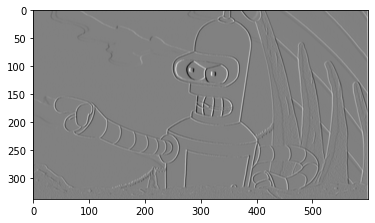

In [7]:
numpy_filt_image = generic_convolution(bender_img_gray, sobel_filter, numpy_sum)
plt.imshow(numpy_filt_image, cmap="gray")

**Testbench for runtime**

Generate random values filled filtering masks and compare the runtime of the 
convolution operation with the size of the filter.

In [8]:
import time 
matrix_sum_runtime = []
numpy_sum_runtime = []

for i in range(3, 40, 2):
  mask_filter = np.random.random((i, i))
  start = time.time()
  matrix_filt_image = generic_convolution(bender_img_gray, mask_filter, matrix_sum)
  end = time.time()
  matrix_sum_runtime.append(end - start)
  start = time.time()
  matrix_filt_image = generic_convolution(bender_img_gray, mask_filter, numpy_sum)
  end = time.time()
  numpy_sum_runtime.append(end - start)

plt.plot([i for i in range(3, 40, 2)], matrix_sum_runtime, color="red")
plt.plot([i for i in range(3, 40, 2)], numpy_sum_runtime, color="blue")


KeyboardInterrupt: 

**CAMERA PIPELINE**

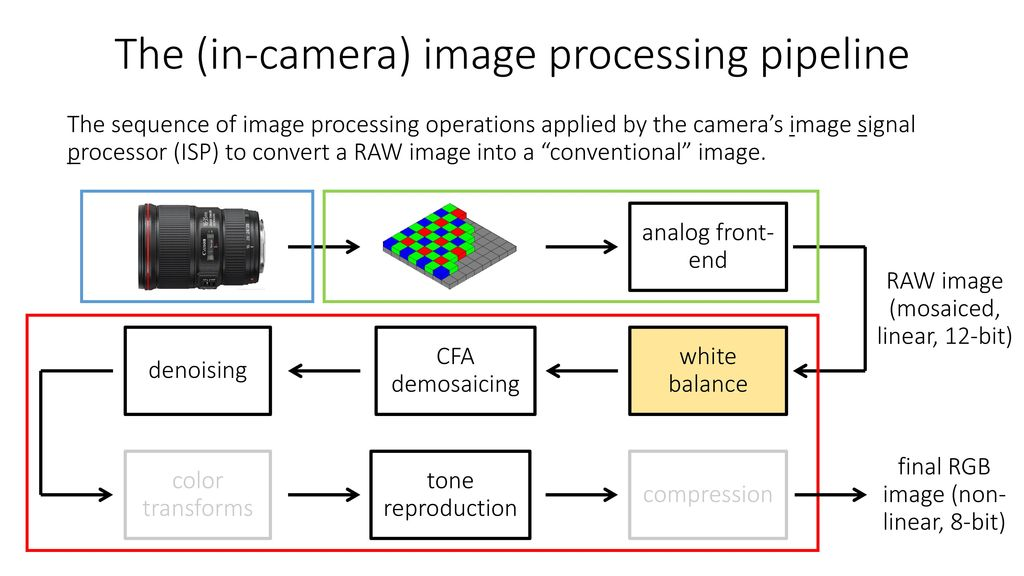

[source](http://graphics.cs.cmu.edu/courses/15-463/):
Ioannis (Yannis) Gkioulekas, Computational Photography, Fall 2020

**2. Bayer pattern filter and demosaicing**

**Bayer colour filter** arrays (CFA) are used to obtain colour images from a single image sensor. the Bayer CFA samples the
coming light into red, green, and blue components according to a checkerboard rectangular sampling grid. 
However, the Bayer CFA approach to obtaining colour images has several disadvantages.  Since each pixel has been made sensitive to a specific spectral band the overall sensor sensitivity is lower than an equivalent sized panchromatic sensor.  Also, due to colour under sampling, the recovered colour images tend to lose sharpness, and visual artefacts in the form of blurred edges and false colours are introduced.

For example: the "normal" forward Bayer filter steps are:

- The BGGR (Blue - Green / Green - Red) filter decomposes this into four rays.
- The four rays hit the sensor, which reads: 81 - 168 / 168 - 235 (sensor values range from 0 - 255);
- The Bayer filter translates this to one RGB pixel with color (235, 168, 81).

The reverse Bayer filter steps or demosaicing:
- RGB pixel with color (235, 168, 81) is split into four pixels with RGB values: (0,0,81) - (0,168,0) / (0,168,0) - (235,0,0).

R and B channels interpolation

There are 4 different cases that can be used for R and B channels creation.

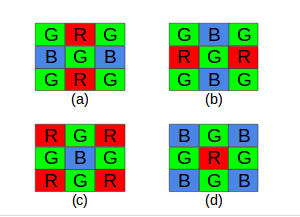

R and G Interpolation

Since we know in advance the pattern we are using (RGGB), we can know the current case by the index.

- All G1 values will be at even rows and odd columns (Case (a)).
- All G2 values will be at odd rows and even columns (Case (b)).
- All B values will be at odd rows and odd columns (Case (c)).
- All R values will be at even rows and even columns (Case d).

**Demosaicing** involves interpolation of missing color values from nearby pixels.
The easiest way is to perform linear interpolation – given the structure of the
Bayer pattern.

References:
1. [Demosaicing python function](https://www.kite.com/python/docs/cv2.demosaicing)
2. [Color Image Demosaicing](https://www.cse.iitb.ac.in/~ajitvr/CS663_Fall2016/demosaicing.pdf)
3. [Bayer Color Filter](http://www.inf.fu-berlin.de/lehre/WS02/robotik/Vorlesungen/Vorlesung2/ComputerVision-2.pdf)


In [12]:
import cv2 as cv 


def bayer_filter(bayer_image):
  red = bayer_image[1::2, 1::2, 0]
  blue = bayer_image[::2, ::2, 2]
  green = bayer_image[1::2, ::2, 1]
  BGR = cv.merge([blue,green,red]) 
  return BGR


def demoisaicing(I):
  # Open image and put it in a numpy array
  srcArray = np.array(I, dtype=np.uint8)
  w, h, _ = srcArray.shape

  # Create target array, twice the size of the original image
  resArray = np.zeros((2*w, 2*h, 3), dtype=np.uint8)
  # Map the RGB values in the original picture according to the BGGR pattern# 
  # Blue
  resArray[::2, ::2, 2] = srcArray[:, :, 2]
  # Green (top row of the Bayer matrix)
  resArray[1::2, ::2, 1] = srcArray[:, :, 1]
  # Green (bottom row of the Bayer matrix)
  resArray[::2, 1::2, 1] = srcArray[:, :, 1]
  # Red
  resArray[1::2, 1::2, 0] = srcArray[:, :, 0]
  return resArray


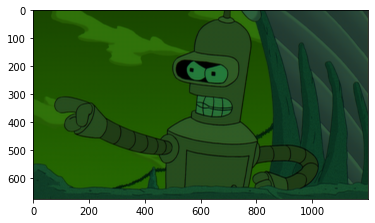

In [14]:
img_bender = cv.imread("bender.png")
RGGB = demoisaicing(img_bender)
plt.imshow(RGGB)

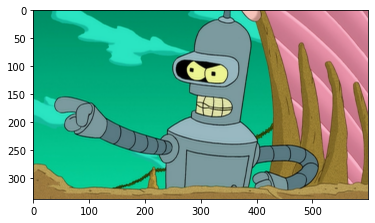

In [15]:
BGR = bayer_filter(RGGB)
plt.imshow(BGR)

**3. Camera calibration**


In the next cell, a set of **point correspondences** to the provided calibration sheet was provided. This consists of a set of XYZ values for the real world coordinates, and the corresponding set of image points coordinates. 

The origin of the WCS was considered with respect to the pattern folding.

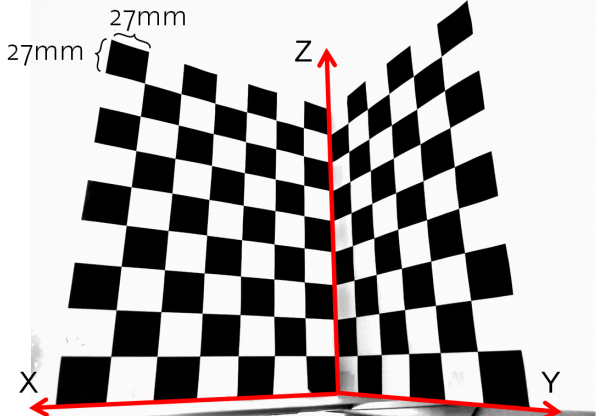



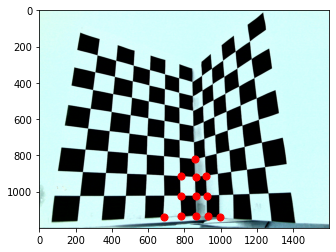

In [21]:
X = [0, 0.027, 0, 0, 0.027, 0, 0.054, 0, 0, 0, 0.027, 0]
Y = [0,	0,	0.027, 0,	0,	0.027,	0, 	0.054, 0,	0, 0, 0.027]
Z = [0,	0, 0, 	0.027, 0.027,	0.027,	0,	0,	0.054,	0.081,	0.054,	0.054]

x = [866.575949367089,	783.031645569620,	930.373417721519,	862.018987341772,
     781.512658227848,	925.816455696203,	685.816455696203,	995.689873417722,	
     863.537974683544,	857.462025316456,	781.512658227848,	921.259493670886]

y = [1132.90506329114,	1135.94303797468,	1135.94303797468,	1026.57594936709,
     1023.53797468354,	1023.53797468354,	1137.46202531646,	1142.01898734177,
     917.208860759494,	821.512658227848,	915.689873417722,	912.651898734177]


calibration_img = cv.imread("image001.jpg")
plt.imshow(calibration_img)
for i in range(len(x)):
  plt.scatter(x[i], y[i], s=50, c='red', marker='o')

2.1 **Data normalization**

As the **Direct Linear Transform** algorithm needs the usage of the Singular Value Decomposition algorithm (SVD), the quality of the data will directly influence the quality of the result. A transformation on the input point is going to be computed such that the distribution for each of the XYZ axes is going to be a Normal Distribution, with zero mean and variance 1. 

Considering the 3D WCS and the 2D image coordinate system equipped with the euclidean norm, the total variance will be **sqrt(2)** for the Image Coordinate System, and **sqrt(3)** for the WCS. 

The first step is going to be data centering, considering as centroid for point clusters the mean value. This can be implemented as follows.
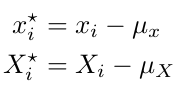

In [22]:
XYZ = np.array([X, Y, Z])
xy = np.array([x, y])

N = len(X)

# shift the input points such that the centroid is the origin
XYZ_mean = XYZ.mean(axis=1)
xy_mean = xy.mean(axis=1)

XYZ_star = np.zeros((3, N))
xy_star = np.zeros((2, N))

for i in range(N):
  XYZ_star[:, i] = XYZ[:, i] - XYZ_mean
  xy_star[:, i] = xy[:, i] - xy_mean


The next step will be computing the transformations for the both coordinate systems, such that the produced data will have the described properties. Next relations for the transformations can be computed for the data, and the matrix form is also given.

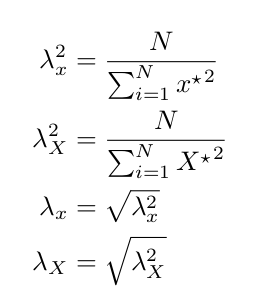

In [23]:
# now compute the scale 

lambda_xy_sq  = N * np.reciprocal(np.sum(np.square(xy_star), axis=1))
lambda_XYZ_sq = N * np.reciprocal(np.sum(np.square(XYZ_star), axis=1))

lambda_xy = np.sqrt(lambda_xy_sq)
lambda_XYZ = np.sqrt(lambda_XYZ_sq)

The form of the transformation matrices will be as follows, where for both Image Coordinate System and the World Coordinate System (WCS), the homogeneous coordinates were used.

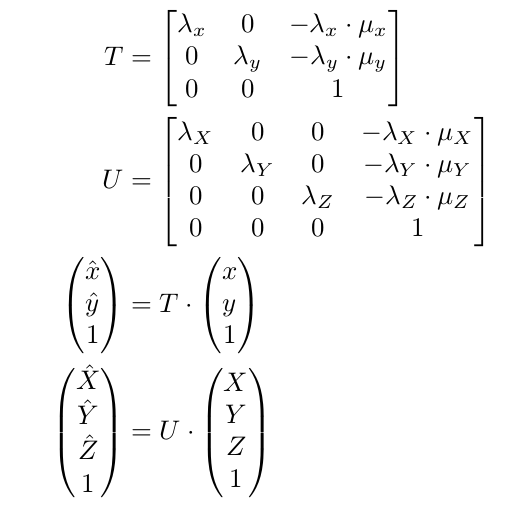

In [24]:
# create T and U similarity matrices
T = np.eye(3)
U = np.eye(4)
for i in range(lambda_xy.shape[0]):
  T[i, i] = lambda_xy[i]
  T[i, 2] = -lambda_xy[i] * xy_mean[i]

for i in range(lambda_XYZ.shape[0]):
  U[i, i] = lambda_XYZ[i]
  U[i, 3] = -lambda_XYZ[i] * XYZ_mean[i]


In [25]:
# Pass the selected points to homogeneous coordinates
xy_homogen = np.ones((3, N))
xy_homogen[0:2, :] = xy

XYZ_homogen = np.ones((4, N))
XYZ_homogen[0:3, :] = XYZ

# apply the computed transformations on the input points
xy_normalized = T @ xy_homogen
XYZ_normalized = U @ XYZ_homogen


Next, the system of equations for the 12 parameters of the 3x4 P matrix can be written as follows.

Then, the SVD solver will be used to get the right *eigenvector*, corresponding to the smallest eigenvalue of the 12x12 matrix A. 

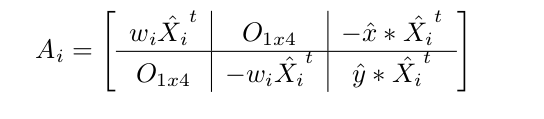


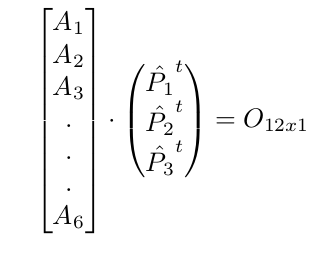

Keep in mind that this solution is computed on normalized coordinates, and the produced projection transformation is going to be the one between the normalized coordinate systems. The transformations have to be inverted in order to compute the P matrix.


In [26]:
#using correspondences, compute the A matrix for DLT
A = np.zeros((12, 12))
temp = np.zeros((2, 12))

for i in range(6):
  temp[0, 0:4] = XYZ_normalized[:, i].T
  temp[0, 8:12] = -xy_normalized[0, i] * XYZ_normalized[:, i].T # multiply by -x
  temp[1, 4:8] = XYZ_normalized[:, i].T
  temp[1, 8:12] = -xy_normalized[1, i] * XYZ_normalized[:, i].T # multiply by -y
  A[2*i: 2*(i+1), :] = temp


# using the SVD decomposition, compute the projection matrix
# keep in mind the projeciton matrix is computed on the normalized coords.
u, s, V = np.linalg.svd(A, full_matrices=True)

P_n = np.zeros((3, 4))
P_n[0, :] = V.T[0:4, 11]
P_n[1, :] = V.T[4:8, 11]
P_n[2, :] = V.T[8:12, 11]

# now, using the transformations from both coordinate systens, compute the P matrix
P = np.linalg.inv(T) @ P_n @ U
print(P)


[[ 2.90472954e+03 -3.43163484e+02 -3.34242709e+02 -5.43581050e+02]
 [ 1.35131680e+03  1.34480285e+03  1.97704973e+03 -7.11077910e+02]
 [ 1.25083767e+00  1.24480479e+00 -4.83520921e-01 -6.27638493e-01]]


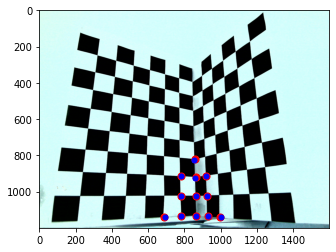

In [27]:
# using the projection matrix, reproject the 3D points in the image
computed_xy = P @ XYZ_homogen
# make sure the result in stil in homogeneous coords.

for i in range(N):
  computed_xy[:, i] = 1/computed_xy[2, i] * computed_xy[:, i]

plt.imshow(calibration_img)
for i in range(len(x)):
  plt.scatter(x[i], y[i], s=50, c='red', marker='o')
  plt.scatter(computed_xy[0, i], computed_xy[1, i], s=25, c='blue', marker='o')


Next, the **projection matrix** can be decomposed as follows:

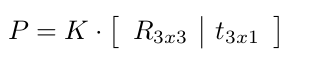

Here, K is the camera matrix, R is a rotation matrix describing the camera position, and the translation for the camera in the WCS can be computed using the camera center (the point C, which is the solution to the equation P * C = 0)

In [28]:
# now let's decompose the projection matrix, to find the camera matrix and
# other available informations
# 1 - take the 3x3 block of P
Ps = P[0:3, 0:3]
Ps_inv = np.linalg.inv(Ps)

# 2 - using QR decomposition compute the camera matrix and the rotation matrix
R_inv, K_inv = np.linalg.qr(Ps_inv)
R = np.linalg.inv(R_inv)

K = np.linalg.inv(K_inv)
K = 1/K[2, 2] * K # K[2, 2] should be 1, up to representation error

Adjustments over the matrices computed with the SVD (correct up to the sign), will be done such that the parameters are justified by their physical meaning.
The next set of relations will be used:
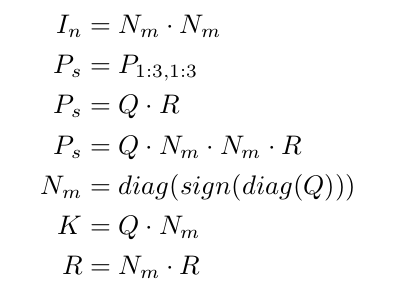

The parameters stated by the camera matrix are:
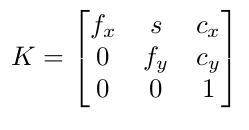

In [29]:
# on the diagonal of K should be the focal lengths of the camera
# modify K such that they are non-negative and R is a rotation
adjustment = np.diag(np.sign(np.diag(K)))
K = K @ adjustment
R = adjustment @ R
print(K)
print(R)

[[1.25276250e+03 8.62158104e+01 1.00593221e+03]
 [0.00000000e+00 1.31743941e+03 7.19355758e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-7.05395580e-01  7.08813851e-01 -1.00681199e-06]
 [-1.87308693e-01 -1.86406762e-01 -9.64452162e-01]
 [-6.83617239e-01 -6.80320104e-01  2.64257502e-01]]


In [30]:
# compute the camera center so P * C = O
u_p, s_p, v_p = np.linalg.svd(P, full_matrices=True)
camera_center = v_p.T[:, 3]
camera_center = 1/camera_center[3] * camera_center # should be in homogeneous coords.
print(camera_center)

# compute the translation t= -R * C
t = -R @ camera_center[:3]
print(t)

[0.22242516 0.28583492 0.01321132 1.        ]
[-0.04570601  0.10768542  0.34302172]


References:

* Richard, H. and A. Zisserman. Multiple View Geometry in Computer Vision. Cambridge: Cambridge University Press, 2000

* https://www.ipb.uni-bonn.de/html/teaching/msr2-2020/sse2-13-DLT.pdf
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7071080/
* https://ch.mathworks.com/help/vision/ref/estimatecameramatrix.html
* https://ch.mathworks.com/matlabcentral/fileexchange/65030-direct-linear-transformation-dlt-solver

4. **Image distorsion**


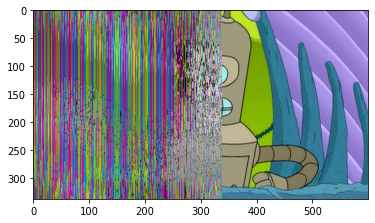

In [34]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np


def distorsion(I):
  A = I.shape[0] / 3.0
  w = 2.0 / I.shape[1]

  shift = lambda x: A * np.sin(1337.0*np.pi*x * w)

  for i in range(I.shape[0]):
     I[:,i] = np.roll(I[:,i], int(shift(i)))

  return I


img_bender = cv.imread("bender.png")
distorsion = distorsion(img_bender)
plt.imshow(distorsion, cmap=plt.cm.gray)
plt.show()